# 네이버 영화 리뷰로 한국어 Word2Vec 실습

### 파이썬의 genism 패키지의 Word2Vec 사용하기

**1) 파이썬의 genism 패키지에는 Word2Vec을 지원하고 있어 손쉽게 단어를 임베딩 벡터로 변환할 수 있음**

In [ ]:
import gensim
gensim.__version__

'3.6.0'

In [ ]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 42.7 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

### 훈련 데이터 이해하기

**1) 훈련 데이터를 다운로드**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f966e2426d0>)

**2) 네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개의 행을 출력**

In [ ]:
train_data = pd.read_table('ratings.txt')

In [ ]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


**3) 총 리뷰 개수를 확인**

In [ ]:
print('리뷰 개수 :',len(train_data))

리뷰 개수 : 200000


**4) 결측값 유무를 확인하고 결측값이 존재하는 행을 제거함**

In [ ]:
print('NULL 값 존재 유무 :', train_data.isnull().values.any())

NULL 값 존재 유무 : True


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('NULL 값 존재 유무 :', train_data.isnull().values.any()) # Null 값이 존재하는지 확인

NULL 값 존재 유무 : False


**5) 결측값이 삭제된 후의 리뷰 개수를 확인**

In [ ]:
print('리뷰 개수 :',len(train_data))

리뷰 개수 : 199992


### 훈련 데이터 전처리하기

**1) 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행**

In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-24-d10eedfa8951>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


**2) 형태소 분석기 Okt를 사용하여 토큰화 작업을 하고 학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거**

In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [12:39<00:00, 263.48it/s]


In [ ]:
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '문화', '산업', '부럽다', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '감사하다'], ['폴리스스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고']]


**3) 토큰화가 된 상태에서 각 리뷰의 길이 분포를 확인**

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


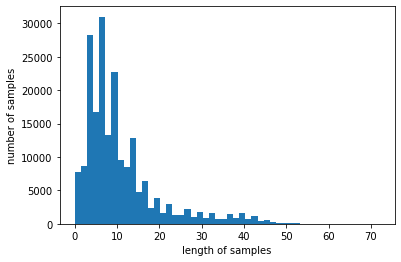

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
     

### Word2Vec 훈련시키기

In [ ]:
from gensim.models import Word2Vec

**1) Word2Vec에 대해서 학습을 진행**

In [ ]:
# size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
# window = 컨텍스트 윈도우 크기
# min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
# workers = 학습을 위한 프로세스 수
# sg = 0은 CBOW, 1은 Skip-gram.
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

**2) Word2Vec 임베딩 행렬의 크기를 확인**

In [ ]:
print('완성된 임베딩 매트릭스의 크기 확인 :', model.wv.vectors.shape)

완성된 임베딩 매트릭스의 크기 확인 : (16477, 100)


**3) '최민식'과 유사한 단어들을 출력**

In [ ]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8710023164749146), ('안성기', 0.8628100752830505), ('이정재', 0.8528807163238525), ('윤제문', 0.8459858298301697), ('설경구', 0.8375144004821777), ('김수현', 0.8344500660896301), ('채민서', 0.8324888944625854), ('유다인', 0.831917405128479), ('서영희', 0.8307336568832397), ('김갑수', 0.8225723505020142)]


**4) '히어로'와 유사한 단어들을 출력**

In [ ]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8722032308578491), ('무협', 0.8636724352836609), ('호러', 0.8634291291236877), ('느와르', 0.8528621196746826), ('블록버스터', 0.8437302112579346), ('무비', 0.8274173736572266), ('물의', 0.8141701817512512), ('정통', 0.8072844743728638), ('물', 0.7960465550422668), ('홍콩', 0.7942720055580139)]
